In [5]:
!pip install datasets

In [6]:
import pandas as pd
import torch
import numpy as np
from textblob import TextBlob
from transformers import AutoTokenizer
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# ✅ Load dataset paths
train_path = "train.tsv"
valid_path = "valid.tsv"
test_path = "test.tsv"

In [14]:
df=pd.read_csv(train_path, sep='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [15]:
# ✅ Label mapping (Convert to Binary: 1=True, 0=False)
LABEL_MAPPING = {
    "true": 1, "mostly-true": 1,
    "half-true": 0, "barely-true": 0, "false": 0, "pants-fire": 0
}

In [16]:
# ✅ Function to preprocess dataset
def preprocess_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.columns = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                  "context1", "context2", "context3", "context4", "context5", "source"]

    # Convert Labels to Binary (1=True, 0=False)
    df["label"] = df["label"].map(LABEL_MAPPING)

    # Handle missing values (replace empty cells with "unknown")
    df.fillna("unknown", inplace=True)

    # Add Sentiment Score (extra feature)
    df["sentiment"] = df["statement"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    return df


In [17]:
# ✅ Load & Process Datasets
train_df = preprocess_data(train_path)
valid_df = preprocess_data(valid_path)
test_df = preprocess_data(test_path)

# ✅ Print dataset stats
print(f"Train Shape: {train_df.shape}, Valid Shape: {valid_df.shape}, Test Shape: {test_df.shape}")
print(train_df.head())

<ipython-input-16-45682fa59b78>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("unknown", inplace=True)


Train Shape: (10240, 15), Valid Shape: (1284, 15), Test Shape: (1267, 15)
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      0  When did the decline of coal start? It started...   
2    324.json      1  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json      0  Health care reform legislation is likely to ma...   
4   9028.json      0  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   



In [21]:
def create_three_key_visualizations(train_df, valid_df, test_df):
    # Combine all datasets for overall analysis
    all_df = pd.concat([train_df, valid_df, test_df], axis=0)

    # 1. Class Distribution with percentages
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='label', data=all_df, palette=['#FF5555', '#55BB55'])

    # Calculate percentages for labels
    total = len(all_df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{count} ({count/total*100:.1f}%)'
        ax.annotate(percentage,
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12)

    plt.title('Distribution of True vs False Claims', fontsize=16)
    plt.xlabel('Label (1=True, 0=False)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap between key features
    plt.figure(figsize=(12, 10))

    # Add statement length as a feature
    all_df['statement_length'] = all_df['statement'].apply(lambda x: len(str(x).split()))

    # Select relevant columns for correlation analysis
    selected_cols = ['label', 'sentiment', 'statement_length',
                     'context1', 'context2', 'context3', 'context4', 'context5']

    # Create correlation matrix
    corr_matrix = all_df[selected_cols].corr()

    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=0.5, cbar_kws={"shrink": .8})

    plt.title('Correlation Heatmap of Features', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. True vs False distribution by political party
    plt.figure(figsize=(14, 8))

    # Get major parties (with more than 100 statements)
    party_counts = all_df['party'].value_counts()
    major_parties = party_counts[party_counts > 100].index.tolist()
    party_df = all_df[all_df['party'].isin(major_parties)]

    # Create cross-tabulation and calculate percentages
    party_truth = pd.crosstab(party_df['party'], party_df['label'])
    party_truth_pct = party_truth.div(party_truth.sum(axis=1), axis=0) * 100

    # Plot stacked bar chart
    ax = party_truth_pct.plot(kind='bar', stacked=True,
                             colormap='coolwarm', figsize=(12, 7))

    # Add value labels on bars
    for c in ax.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center')

    plt.title('Percentage of True vs False Claims by Political Party', fontsize=16)
    plt.xlabel('Political Party', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(['False', 'True'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [22]:
for df_name, df_ in zip(['Train', 'Validation', 'Test'], [train_df, valid_df, test_df]):
    print(f"\nChecking {df_name} DataFrame:")
    for col in df_.select_dtypes(include='object').columns:
        unique_vals = df_[col].unique()
        if any(isinstance(val, str) and val.lower() == 'unknown' for val in unique_vals):
            print(f"Column '{col}' contains 'unknown'")



Checking Train DataFrame:
Column 'subject' contains 'unknown'
Column 'speaker' contains 'unknown'
Column 'job' contains 'unknown'
Column 'state' contains 'unknown'
Column 'party' contains 'unknown'
Column 'context1' contains 'unknown'
Column 'context2' contains 'unknown'
Column 'context3' contains 'unknown'
Column 'context4' contains 'unknown'
Column 'context5' contains 'unknown'
Column 'source' contains 'unknown'

Checking Validation DataFrame:
Column 'job' contains 'unknown'
Column 'state' contains 'unknown'
Column 'source' contains 'unknown'

Checking Test DataFrame:
Column 'job' contains 'unknown'
Column 'state' contains 'unknown'
Column 'source' contains 'unknown'


In [23]:
import numpy as np

def clean_unknowns(df):
    df = df.replace('unknown', np.nan)
    return df

train_df = clean_unknowns(train_df)
valid_df = clean_unknowns(valid_df)
test_df = clean_unknowns(test_df)


<ipython-input-23-2e2f88c2cdee>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('unknown', np.nan)


In [24]:
for df in [train_df, valid_df, test_df]:
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')  # or errors='coerce' to convert non-numeric to NaN


<ipython-input-24-c25b3d861cc1>:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')  # or errors='coerce' to convert non-numeric to NaN


<ipython-input-21-95a8376817b3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=all_df, palette=['#FF5555', '#55BB55'])


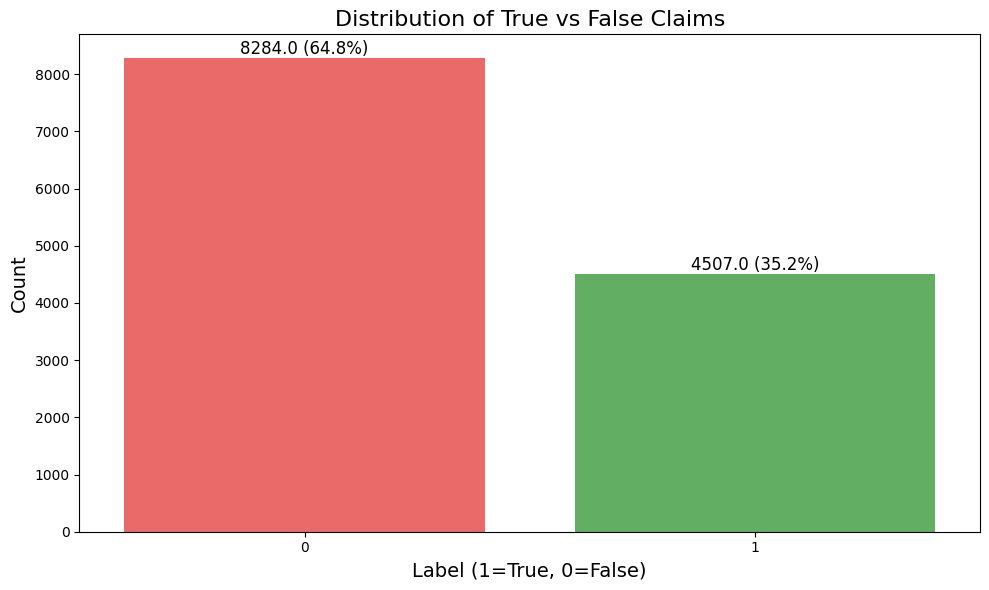

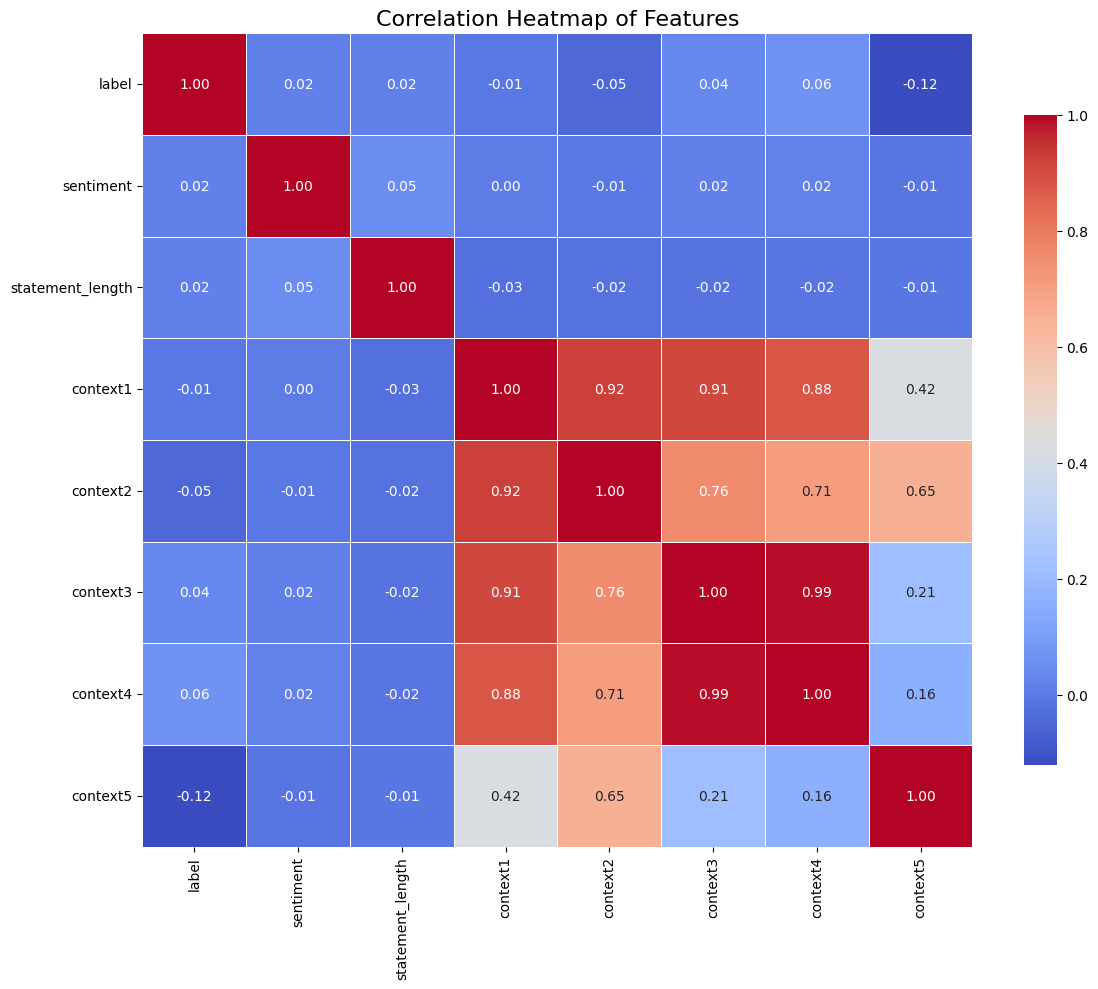

<Figure size 1400x800 with 0 Axes>

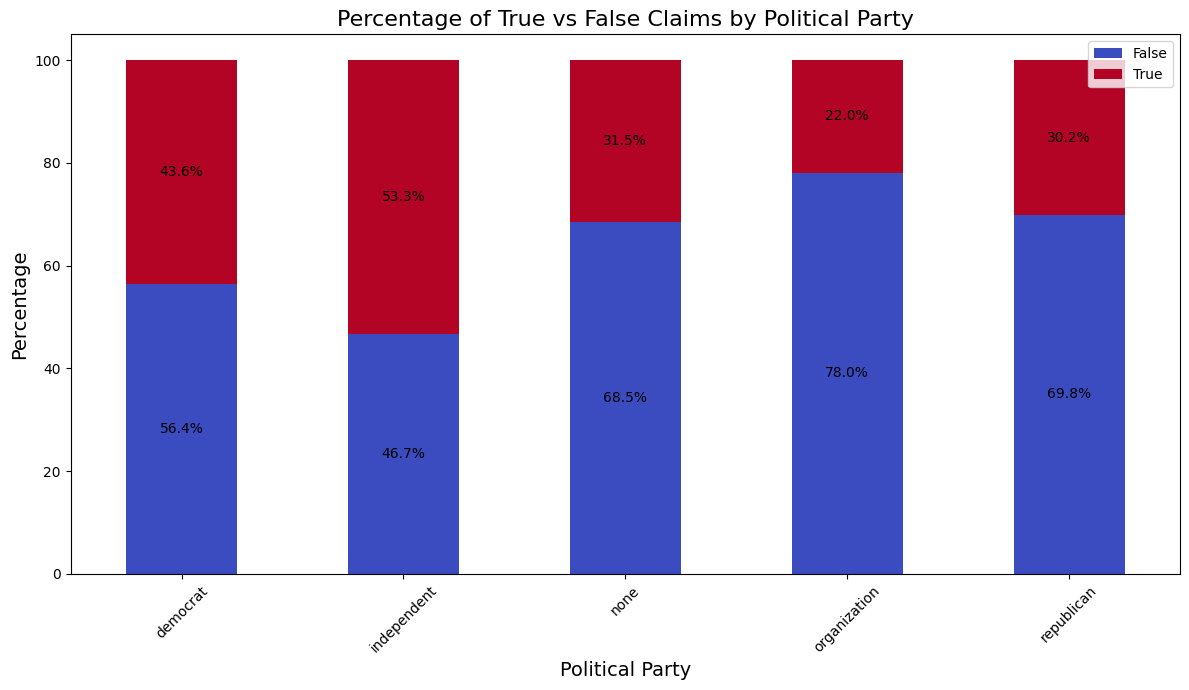

In [26]:
create_three_key_visualizations(train_df, valid_df, test_df)

In [27]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# ✅ Load Tokenizer & Model
BERT_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2).to("cuda")

# ✅ Prepare Dataset
def tokenize_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=256)

train_dataset = HFDataset.from_pandas(train_df[["statement", "label"]])
valid_dataset = HFDataset.from_pandas(valid_df[["statement", "label"]])
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["statement"])
valid_dataset = valid_dataset.remove_columns(["statement"])
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ✅ Training Config
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    logging_steps=20,
    load_best_model_at_end=True,
    fp16=True,
)

# ✅ Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()

# ✅ Evaluate BERT Model
results = trainer.evaluate()
print(f"📊 BERT Test Accuracy: {results['eval_loss']:.2f}")
# 796c5b15b3cc79b8a5436762178b899bdecc9021

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-5815ed635b59>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raiahsan998 (raiahsan998-u-s-bank) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.638900,0.595087
2,0.562600,0.592142
3,0.479100,0.643038
4,0.384400,0.695585


📊 BERT Test Accuracy: 0.59


In [28]:
# ✅ Load RoBERTa Model
ROBERTA_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_MODEL, num_labels=2).to("cuda")

# ✅ Train & Evaluate using Same Code as BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()
results = trainer.evaluate()
print(f"📊 RoBERTa Test Accuracy: {results['eval_loss']:.2f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-028f759af54b>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.672700,0.634842
2,0.643600,0.606944
3,0.631800,0.606048
4,0.613100,0.598726


📊 RoBERTa Test Accuracy: 0.60


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer

# ✅ Load Tokenizer & BERT Model
HYBRID_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(HYBRID_MODEL)

# ✅ Tokenize Text Data
def tokenize_statements(statements):
    return tokenizer(statements, padding="max_length", truncation=True, max_length=256, return_tensors="pt")

train_tokens = tokenize_statements(train_df["statement"].tolist())
valid_tokens = tokenize_statements(valid_df["statement"].tolist())

# ✅ Convert to TensorDataset
train_labels = torch.tensor(train_df["label"].tolist())
valid_labels = torch.tensor(valid_df["label"].tolist())
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
valid_dataset = TensorDataset(valid_tokens["input_ids"], valid_tokens["attention_mask"], valid_labels)

# ✅ Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# ✅ Define Hybrid Model (BERT + CNN + LSTM)
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # ✅ Use AutoModel (not Classification)
        self.bert = AutoModel.from_pretrained(HYBRID_MODEL)

        # ✅ CNN Layer
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)

        # ✅ LSTM Layer
        self.lstm = nn.LSTM(128, 64, batch_first=True)

        # ✅ Fully Connected Layer
        self.fc = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        # ✅ Pass through BERT and get hidden states
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state  # (batch_size, seq_length, 768)

        # ✅ Rearrange for Conv1D: (batch_size, 768, seq_length)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)  # (batch_size, 128, seq_length)

        # ✅ Rearrange for LSTM: (batch_size, seq_length, 128)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)  # (batch_size, seq_length, 64)

        # ✅ Take the last LSTM output
        x = x[:, -1, :]  # (batch_size, 64)

        # ✅ Fully Connected Layer
        x = self.fc(self.dropout(x))  # (batch_size, 2)
        return x

# ✅ Initialize Model
model = HybridModel().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# ✅ Train Hybrid Model
for epoch in range(4):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ✅ Evaluate Hybrid Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"📊 Hybrid Model Test Accuracy: {accuracy * 100:.2f}% ✅")


Epoch 1, Loss: 402.9974
Epoch 2, Loss: 376.0938
Epoch 3, Loss: 319.1230
Epoch 4, Loss: 229.1373
📊 Hybrid Model Test Accuracy: 62.46% ✅
